# Univariate satellite image time series classification with ROCKET

## What is "ROCKET"?

ROCKET is a **new method** for time series classification that uses **convolutional kernels** as found in convolutional neural networks. 

Discriminative patterns in time series are often warped, i.e. a pattern might appear at different positions in time. Convolutional kernels can, in combination with certain pooling mechanisms, detect these patterns in a time series.

The **ROCKET method transforms time series using large numbers of convolutional kernels** to derive features that are fed into a simple, e.g. linear, classifier.

Dempster, Petitjean and Webb [1] applied their method on 85 datasets from the UCR archive (https://www.cs.ucr.edu/~eamonn/time_series_data_2018/) and compared it to other classification methods applied to the same datasets. **The authors claim to achieve state-of-the-art accuracies at low computational costs.**

\*A. Dempster, F. Petitjean, and G. I. Webb, “ROCKET: Exceptionally fast and accurate time series classification using random convolutional kernels,” arXiv e-prints, p. arXiv:1910.13051, Oct 2019

## Experiments in this notebook

**ROCKET stands out when compared to other time series classification methods because LITTLE TO NONE (HYPER-)PARAMETERS need to be tuned.**

What you will see in this notebook therefore is a comparison of ROCKET to other methods with similar characteristics.

1. **ROCKET with different numbers of kernels** (250 and 1000)
2. **LightGBM Classifier**
3. **Random Forest Classifier** 

The latter two methods are frequently used in land cover classification because they typically yield decent accuracies on SITS **WITHOUT ANY HYPERPARAMETER TUNING**. 

Above methods are applied **to an openly accessible dataset of Sentinel-2 satellite images** (various training/test dataset sizes).

## Dataset: Sentinel-2 satellite image time series

The dataset I use here is of very similar specifications as the one used by Dempster et al. for their scalability experiment.

* as the described implementation of ROCKET handles **univariate** time series, the vegetation index NDVI is used as the independent variable here


* labels: each pixel is labelled with a land cover class. There is a total of 10 classes in the full dataset; the **spatial subset used here and in the eo-learn blog post, however, contains only 6 land cover classes** of relevant numbers of pixels.


* the dataset was generated doing the following pre-processing steps:
  * calculation of **vegetation index NDVI**
  * **masking of clouded observations**
  * **interpolation of missing values and temporal resampling to 5-day intervals** (approximate revisit time of the Sentinel-2 constellation)
  * **smoothing** of time series (moving average with window of 4 timesteps, or 20 days, respectively)


* The sample pixels stem from **4 different** adjacent regions and the origin of each sample pixel ("group") is recorded in this dataset. Groups are later used in order to make train/test splits.

More details about the generation of the dataset can be found in the notebook `01_prepare_Sentinel-2_SITS_dataset.ipynb`.

## Load SITS dataset

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from pathlib import Path

In [2]:
dataset_suffix = '4x12000px__interval_5d__sm'

data_dir = Path('data')

with open(data_dir / f'features__{dataset_suffix}.pkl', mode='rb') as f:
    features = pickle.load(f)
with open(data_dir / f'labels__{dataset_suffix}.pkl', mode='rb') as f:
    labels = pickle.load(f)
with open(data_dir / f'timestamps__{dataset_suffix}.pkl', mode='rb') as f:
    timestamps = pickle.load(f)

**Let's plot the time series of a subset of all the time series:**

In [3]:
np.random.seed(0)

# select k pixels from first fold
k = 500
subset_size = min(k, features[0].shape[1])
subset = np.random.randint(0, features[0].shape[1], size=subset_size)
reflectance = features[0][:, subset, 0, 0]
lc_class = labels[0][0, subset, 0, 0]
time_step = np.array([i for i in range(len(timestamps[0]))]).astype('int')

# build a tidy data frame
df_list = []
for i in range(subset_size):
    data = np.stack([time_step, reflectance[..., i], np.repeat(lc_class[i], reflectance.shape[0])]).T
    df = pd.DataFrame(data, columns=['time step', 'ndvi', 'land cover class']).astype({'land cover class': 'int'})
    df['time step'] = df['time step'].astype('int')
    df['land cover class'] = df['land cover class'].replace(to_replace={1: 'cultivated land', 2: 'forest', 
                                                                       3: 'grassland', 4: 'shrubland', 
                                                                       5: 'water', 8: 'artificial surface'})
    df = df[df['land cover class'] != 0]
    df_list.append(df)
df = pd.concat(df_list)

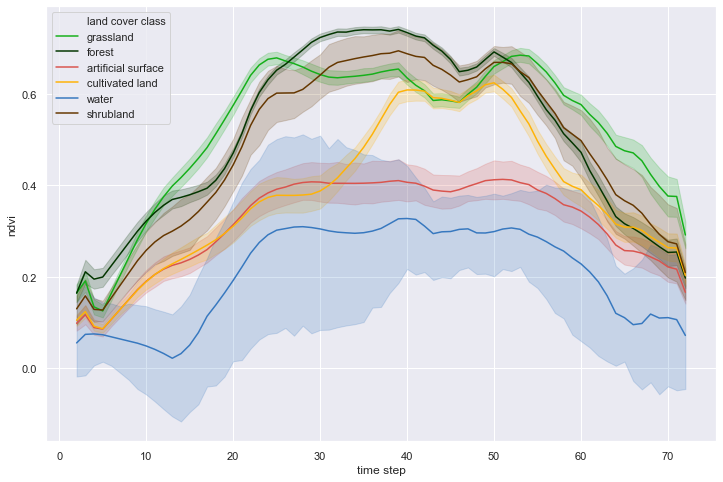

In [4]:
# plot time series
sns.set(rc={'figure.figsize':(12, 8)})
colors = ['green', 'dark green', 'pale red', 'amber', 'windows blue', 'brown']
g = sns.lineplot(x='time step', y='ndvi', hue='land cover class',
                 palette=sns.xkcd_palette(colors), 
                 data=df)

... as one can see, **each land cover class has its own characteristic progression over time** regarding its vegetation index. 

## Evaluation of classifiers

In the following, two different parameterizations of ROCKET are evaluated:
* **250 kernels**
* **1000 kernels**

In order to get the full picture of the power of the classifier, we are going to evaluate **10 different training set sizes**, from 2^6 to 2^16 (i.e. from 64 to 32768).

ROCKET accuracy and performance measures are always shown alongside results from these two other classifiers:
* the very efficient **LightGBM Classifier**, as also used in the eo-learn blog post (see link above), with default settings
* **Random Forest Classifier**, whose default settings in sci-kit learn typically yield decent accuracies on all kinds of datasets

In order to make a fair comparison possible, the kernel function (module rocket_functions) by Dempster et al. is modified to run not in parallel, but on only one CPU.

For each classifier, **three different metrics** will be recorded:
* **accuracy** (fraction of correct predictions)
* **duration of training**
* **duration of prediction** for 1000 test samples

Accuracy measurement is done through **4-fold Grouped Cross-Validation**. In our time series dataset, the geographic region a sample stems from is recorded. Using this information, a cross-validation is carried out where each time samples from a different region are used as the test set.

In [5]:
from sklearn.linear_model import RidgeClassifierCV
from rocket_functions import generate_kernels, apply_kernels
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from tqdm import tqdm
import timeit

### Prepare features and label for classification
* only keep pixels of the classes with decent numbers of pixels in the dataset (classes 1, 2, 3, 4, 5 and 8)


* get group id for each row for train-test-split

In [6]:
# groups for GroupKFold Cross-Validation: group id for each row
groups = []
for i in range(len(labels)):
    group = [i for j in range(len(labels[i].flatten()))]
    groups.extend(group)

# eliminate rows with unwanted label
X = np.concatenate(features, axis=1).swapaxes(0,1)[..., 0, 0]
y = np.concatenate(labels, axis=1).flatten()[...,np.newaxis]
groups = np.array(groups)[...,np.newaxis]
X_y_groups = np.concatenate([X, y, groups], axis=1)
keep_labels = [1, 2, 3, 4, 5, 8]
X_y_groups = X_y_groups[np.isin(X_y_groups[:, -2], keep_labels)]

# fill NaNs
X_y_groups_full = np.nan_to_num(X_y_groups)
print(X_y_groups_full.shape)

(47793, 75)


### Loop through different training set sizes and classifiers

In [7]:
# list to record results
samples = []
samples_test = []
classifier = []
scores = []
time_train = []
time_test = []

subset_sizes = [2**i for i in range(6, 16, 1)] # range from 64 to 32768

# loop through subset set sizes (k of each group) 
for k in tqdm(subset_sizes):
    subsets = []
    groups_tmp_ = np.array(X_y_groups_full[:, -1]).astype('int')
    for group in np.unique(groups):
        k_per_patch = int(np.rint(k / (len(np.unique(groups)) - 1)))  # a third of k per patch
        subsets.append(X_y_groups_full[groups_tmp_==group,:][:k_per_patch,:])
    X_y_groups = np.concatenate(subsets, axis=0)

    # get X, y, and groups
    X = np.array(X_y_groups[:, :-2])
    y = np.array(X_y_groups[:, -2]).astype('int')
    groups = np.array(X_y_groups[:, -1]).astype('int')

    # loop through classifiers
    classifier_names = ['LGBMClassifier', 'RandomForestClassifier', 'ROCKET_250', 'ROCKET_1000']
    for clf_name in classifier_names: 
        for i in np.unique(groups):            
            # 1000 test samples from group i
            X_test = X_y_groups_full[groups_tmp_==i,:][:1000, :-2]
            y_test = X_y_groups_full[groups_tmp_==i,:][:1000, -2]
            
            # training samples from other 3 groups
            X_train = X[np.nonzero(groups!=i)[0], :]
            y_train = y[np.nonzero(groups!=i)[0]]

            # instantiate classifier
            start = timeit.default_timer()  # time training time
            if clf_name.startswith('ROCKET_'):
                clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                k_kernels = int(clf_name.split('_')[-1])
                kernels = generate_kernels(X_train.shape[1], k_kernels)
                X_train = apply_kernels(X_train, kernels) 
            else:
                clf = eval(clf_name + '(n_jobs=1)')  # instantiate classifier dynamically; like the ROCKET function
                # (which I modified to not run in parallel), only one CPU is used

            # calculate score
            clf.fit(X_train, y_train)
            time_train.append(timeit.default_timer() - start)
            start = timeit.default_timer()  # time prediction time
            if clf_name.startswith('ROCKET'):
                X_test = apply_kernels(X_test, kernels)
            y_pred = clf.predict(X_test)
            time_test.append(timeit.default_timer() - start)
            score = accuracy_score(y_test, y_pred)

            # collect results
            samples.append(k)
            samples_test.append(len(y_test))
            classifier.append(clf_name)
            scores.append(score)

100%|██████████████████████████████████████████████████████████| 10/10 [24:04<00:00, 144.45s/it]


In [8]:
# make a tidy data frame of the results for plotting with seaborn
df = pd.DataFrame({'training samples': samples, 'classifier': classifier, 'accuracy': scores, 'training time': time_train, 
                  'test samples': samples_test, 'prediction time': time_test}) 

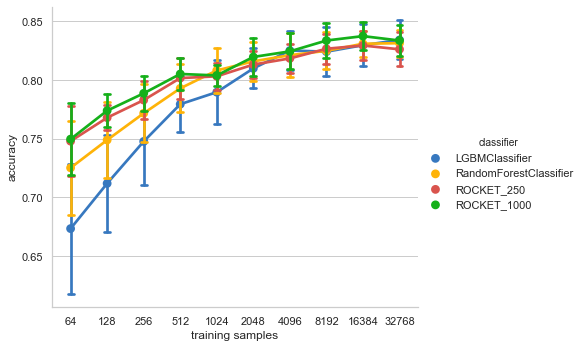

In [9]:
sns.set(style="whitegrid")
colors = ["windows blue", "amber", "pale red", "green"]
g = sns.catplot(x="training samples", y="accuracy", hue="classifier", 
                capsize=.16, kind="point",  palette=sns.xkcd_palette(colors),
                aspect=1.25, ci='sd', data=df)

The first impression from this: it **clearly shows that BOTH ROCKET CLASSIFIERS ACHIEVE IMPRESSIVE ACCURACIES!** Especially for smaller subset sizes, the difference to Random Forest and Light-GBM is noticeable.

Furthermore the **variability** (see whiskers indicating the standard deviation), **is quite a bit smaller than with Random Forest or Light-GBM.** This certainly is a desirable characteristic because **it means that ROCKET is a robust classifier** that returns reliable and consistent accuracies, regardless of smaller alterations between different training sample sets.

**Since the details get a bit lost in the above plot, let's plot the experiment result only for 512 samples and more:**

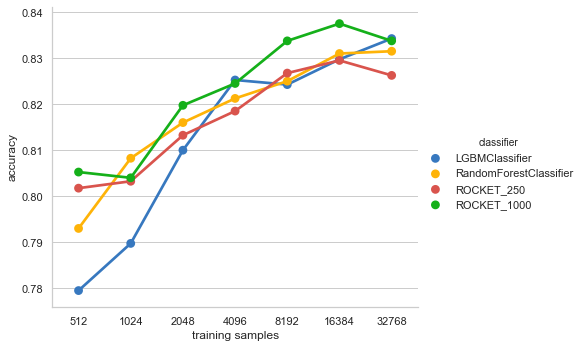

In [10]:
sns.set(style="whitegrid")
data = df.loc[df['training samples']>=512]
g = sns.catplot(x="training samples", y="accuracy", hue="classifier", 
                capsize=.16, kind="point",  palette=sns.xkcd_palette(colors),
                aspect=1.25, ci=None, data=data)

Up to 512 samples, ROCKET experiments achieve clearly better accuracies than Light-GBM and Random Forest. Above that, accuracy of ROCKET_250 loses to Random Forest, and starting with 4096 samples also to Ligth-GBM.

**ROCKET with 1000 kernels** (ROCKET_1000) **quite consistently achieves the highest accuracies throughout nearly all training set sizes** - although closely followed by the Random Forest Classifier, which shows a similar level of consistently high accuracies. 

Nevertheless, it **_looks like ROCKET is a promising replacement for other state-of-the-art methods in SITS classification regarding accuracy!_**

Light-GBM yields mostly dissappointing results, not only regarding average accuracy, but in particular the variability between different folds. 

**WE CAN CONCLUDE THAT REGARDING ACCURACY, ROCKET IS HARD TO BEAT AS LONG AN APPROPRIATE NUMBER OF KERNELS IS CHOSEN!** 

However, in order to get a proper picture of the performance of ROCKET when compared to the other methods, **we should look at training and prediction times:**

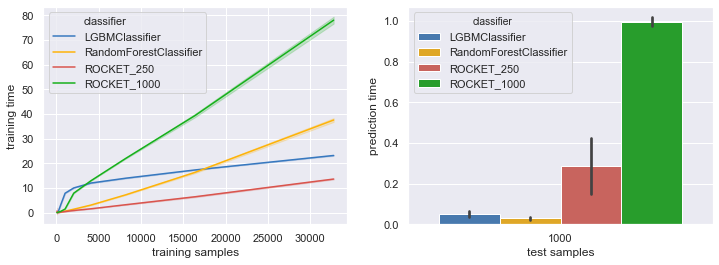

In [11]:
sns.set()
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.lineplot(x='training samples', y='training time', hue='classifier',
             palette=sns.xkcd_palette(colors), ax=axs[0], ci='sd', data=df)
sns.barplot(x='test samples', y='prediction time', hue='classifier',
             palette=sns.xkcd_palette(colors), ax=axs[1], ci='sd', data=df)
plt.show()

**Training speed of ROCKET is heavily dependent on the number of kernels** and increases linearly with the number of samples (left diagram). The time difference of the two different kernel settings amounts to orders of magnitude (e.g. ~10 seconds for 250 kernels compared to ~80 seconds for the largest training dataset, left diagram). **ROCKET with 250 kernels is even faster than Light-GBM and Random Forest!**

**When looking at the prediction times** (right diagram), however, **Light-GBM and Random Forest are hard to beat.** ROCKET still has acceptable speed, though, with 0.3 and 1 millisecond per time series, respectively.

**Up to 512 samples, ROCKET has a really great cost-benefit ratio:** it achieves best accuracies (more or less the same as ROCKET_1000), while being the fastest concerning training time.

## Conclusion
Whether ROCKET is superior over the other methods tested above depends on the training samples available in your training dataset. 
* **If accuracy is your only concern, but you don't want to spend time and research on extensive hyperparameter tuning, ROCKET with 1000 or more kernels should be your method of choice!** - ROCKET_1000 shows highest accuracies, regardless of training set size. However, it is also most expensive regarding computation time (training and prediction).


* **If you want a good trade-off between accuracy and training speed, ROCKET with 250 kernels is quite efficient for small to medium training datasets** - ROCKET_250 achieves decent accuracies and is trained very fast for datasets up to 512 samples.


* **If large numbers of samples need to be predicted cheaply, Light-GBM and Random Forest are very hard to beat.** Although I suspect that Random Forest and Light-GBM work well on this particular dataset because the warping between the time series of different pixels is quite small because all sample pixels lie within close proximity of a few kilometers). 


* In any other case, one should consider all of the options and run some comparisons like the above!

## Further investigations

With the above results in mind, there are some points that could be interesting for further investigation:

1. **Ways to apply ROCKET on multi-variate datasets** (Sentinel-2 is a sensor with 13 spectral bands, the NDVI only reflects two of them!)


2. **Performance of ROCKET (and other time series classificaton methods) on time series where time warping is more present**, i.e. datasets where climatic differences lead to temporal shifts within training samples of the same land cover class. The hypothesis in that case would be that the gap between ROCKET and the decision tree ensembles (Light-GBM, Random Forest) regarding accuracy gets even bigger because the ensembles do not actually consider temporal progression (they consider each time step as an isolated feature).


3. **Analysis of differences between classifiers beyond the bare accuracy numbers.** E.g.: Can we identify strengths/weaknesses of each classifier regarding particular land cover classes?